In [1]:
wd <- dirname(dirname(getwd()))
setwd(wd)

In [2]:
source(paste0(wd,"/mission_control/treasure_map.R"))
source(paste0(wd,"/mission_control/helpers/figures/figure2_theme.R"))

In [3]:
suppressMessages(library(tidyverse))
suppressMessages(library(ggrepel))
suppressMessages(library(gridExtra))
suppressMessages(library(ggpubr))
suppressMessages(library(ggcorrplot))

Warning message:
“package ‘tibble’ was built under R version 3.6.3”Warning message:
“package ‘tidyr’ was built under R version 3.6.3”Warning message:
“package ‘purrr’ was built under R version 3.6.3”Warning message:
“package ‘dplyr’ was built under R version 3.6.3”Warning message:
“package ‘forcats’ was built under R version 3.6.3”

### 0 - Read in prepared data

In [4]:
ingredients <- readRDS(paste0(TMP_DIR,"exhaustive-plots-base.Rds"))
labels <- readRDS(paste0(TMP_DIR,"exhaustive-plots-labels.Rds"))
threshold <- -log10(ingredients$by_05_fdr)[1]
cpi_go <- readRDS(paste0(I_DIR, "cpi_go.Rds"))

In [5]:
geneset_names = data.table::fread(paste0(REF_DIR, "CPI_genesets.txt"))
colnames(geneset_names)[1] = "feature"

### 1 - colors

In [6]:
#fill_map <- list("Clinical"="#9E7788","CNV/SVs"="#B3DE69","HLA"="#FFFF99","RNA"="#FC913A","Somatic"="#80B1D3")
fill_map <- list("Clinical"="#9E7788","CNV/SVs"="#B3DE69","HLA"="#FFFF99","RNA"="grey","Somatic"="#80B1D3")
fill2_map <- list( "Cluster 1 Gene Set" = "#8DD3C7", "Cluster 2 Gene Set" = "#BEBADA","Gene Set" = "black","RNA" = "grey")
size_map <- list( "TRUE" = 3, "FALSE" = 2)
alpha_map <- list( "TRUE" = 1, "FALSE" = .4)
color_map <- list( "TRUE" = "black", "FALSE" = "white")
color_map2 <- list( "In Cluster" = "black", "Not in Cluster" = "white")

### 2 - Prepare data

In [7]:
names_map <- list("isofox_gene_set_mariathan_Cell_cycle" = "Cell Cycle",
                  "isofox_gene_set_HALLMARK_G2M_CHECKPOINT" = "G2M Checkpoint",
                  "isofox_gene_set_prolif" = "Proliferation Potential",
                  "isofox_gene_set_HALLMARK_ANGIOGENESIS" = "Angiogenesis",
                  "isofox_gene_set_KEGG_ECM_RECEPTOR_INTERACTION" = "ECM receptor interaction", 
                  "isofox_gene_set_HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION" = "EMT",
                  "isofox_gene_set_KEGG_FOCAL_ADHESION" = "Focal Adhesion",
                  "isofox_gene_set_Pan_TBRS" = "TGFB Response signature")
namer <- function(i) { if( i %in% names(names_map)){ names_map[[i]]} else {""}}

In [8]:
typer <- function( big_group, Group, cor_tgfb, cor_prolif ){
    if( Group == "Gene Set"){
        if( cor_tgfb > .8 ){ "Cluster 2 Gene Set"} 
        else if ( cor_prolif > .8 ) {"Cluster 1 Gene Set"}
        else {"Gene Set"}
    } else {
        big_group
    }
}

In [9]:
base_data <- (
    ingredients 
      %>% filter(
           !grepl("ciber", feature),
           feature != "clinical_systemic_composite",
           dataset == "all", 
           model == "os",
           covariates == "residuals",
           !grepl("cluster", feature),
           !grepl("vhio", feature),
           !grepl("rand", feature),
           ! feature %in% c("isofox_gene_set_tcell_cluster", "tcell", "tmb", "tgfb","prolif", "isofox_gene_set_prolif_cluster", "isofox_gene_set_tgfb_cluster"),
           cor_tmb < .3, cor_tcell < .3, cor_pretreat < .3
      )
      %>% mutate(in_cluster = ifelse(Group != "Gene Set" & log10_p > threshold, "In Cluster", "Not in Cluster"))
      %>% rowwise()
      %>% mutate( gene_set_type = typer(big_group, Group, cor_tgfb, cor_prolif))
      %>% mutate( highlight = namer(feature) )
      %>% mutate( big_group = factor(big_group, levels = c("RNA", "Somatic", "Clinical", "CNV/SVs", "HLA")))
)

### 3 - Plot function

In [10]:
plots_go <- function( settings ){(
      ggplot( settings$data, settings$aes) + 
        geom_point(shape = 21, stroke = 0.3) + 
        scale_x_continuous(n.breaks = 3)  +
        scale_y_continuous(breaks = c(seq(0,8,2)), limits = c(0,8.5)) + 
        scale_size_manual(values = unlist(size_map))  +
        scale_alpha_manual(values = unlist(alpha_map)) + 
        scale_color_manual(values = unlist(color_map) ) + 
        scale_fill_manual(values = unlist(fill_map), limits = force) + 
        geom_hline( yintercept = threshold, linetype="dashed", color = "black" ) + 
        xlab( settings$x ) + ylab("-Log10 p-value") +  ggtitle( settings$title) +
        settings$theme
)}

### 4 - Settings

In [11]:
guides_main <- guides(alpha = "none", size = "none", color = "none", fill = guide_legend(override.aes = list(size=4)))

In [12]:
aes_main <- aes(x = plot_est, y = log10_p, fill = big_group, size = log10_p > threshold, alpha = log10_p > threshold, color = log10_p > threshold ) #+ guides_main
aes_tgfb <- aes(x = cor_tgfb, y = log10_p, fill = gene_set_type, size = cor_tgfb > .5 , alpha =  log10_p > threshold , color = log10_p > threshold ) #+ guides_main
aes_prolif <- aes(x = cor_prolif, y = log10_p, fill = gene_set_type, size = cor_prolif > .5, alpha =  log10_p > threshold , color = log10_p > threshold ) #+ guides_main

In [13]:
plts <- list( 
    "main" = list("data" = base_data %>% filter(Group != "Gene Set"), 
                  "theme" = base_theme,
                  "x" = "1 / OS Hazard Estimate",
                  "title" = "OS Residuals vs All Features",
                  "aes" = aes_main,
                  "labels" = FALSE),
    "remaining" = list("data" = base_data %>% filter(cor_tgfb < .3, cor_prolif < .3, cor_tmb < .3, cor_tcell < .3, cor_pretreat < .3), 
                  "theme" = base_theme,
                  "x" = "1 / OS Hazard Estimate",
                  "title" = "OS Residuals vs Remaining Features",
                  "aes" = aes_main,
                  "labels" = FALSE),
    "clust1" = list("data" = base_data %>% filter(big_group %in% c("RNA")),
                    "theme" = base_theme, 
                    "x" = "Correlation to Cluster 1 Mean",
                    "title" = "OS Residuals vs RNA Features (with Gene Sets)",
                    "aes" = aes_prolif,
                    "labels" = FALSE),
    "clust2" = list("data" = base_data %>% filter(big_group %in% c("RNA")),
                    "theme" = base_theme, 
                    "x" = "Correlation to Cluster 2 Mean",
                    "title" = "OS Residuals vs RNA Features (with Gene Sets)",
                    "aes" = aes_tgfb,
                    "labels" = FALSE))

### 5 - Go Go

#### Figure 3 a and d

In [14]:
fig_3a <- plots_go(plts$main) + theme(legend.position = c(0.8, 0.85)) + guides_main  + geom_text(x = 1, y = threshold + .25, label = "BY Threshold", size = 4, color = "black")

In [15]:
fig_3d <- plots_go(plts$remaining) + theme(legend.position = c(0.8, 0.85)) + guides_main  + geom_text(x = 1, y = threshold + .25, label = "BY Threshold", size = 4, color = "black")

- filter

In [16]:
clust1 <- (
  plots_go(plts$clust1) 
    + scale_fill_manual(values = unlist(fill2_map), limits = force) 
    + geom_label_repel(data = base_data %>% filter(gene_set_type == "Cluster 1 Gene Set"), inherit.aes = FALSE,
                     aes(x = cor_prolif, y = log10_p, label = highlight), size = 4, nudge_y = 1.2, fill = fill2_map$`Cluster 1 Gene Set`)
    + theme(plot.title = element_text(hjust = .5, size = 15, vjust = 4))
)

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.


In [17]:
clust2 <- (
  plots_go(plts$clust2) 
    + scale_fill_manual(values = unlist(fill2_map), limits = force) 
    + geom_label_repel(data = base_data %>% filter(gene_set_type == "Cluster 2 Gene Set"), inherit.aes = FALSE,
                     aes(x = cor_tgfb, y = log10_p, label = highlight), size = 3, nudge_y = 1.2, fill = fill2_map$`Cluster 2 Gene Set`)
    + theme(axis.title.y = element_blank(), axis.text.y = element_blank(),
            plot.title = element_text(hjust = .5, size = 14, vjust = 4)) +
    theme(legend.position = c(0.2, 0.85), , legend.text = element_text(size = 12)) + guides_main
    #theme(legend.position = "right", , legend.text = element_text(size = 12)) + guides_main
)

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.


In [18]:
fig_3c <- as_ggplot(arrangeGrob( clust1, clust2, ncol = 2))

### 6 - Figure 3 - B

In [19]:
drop_features <- c("tcell", "tmb", "prolif","tgfb","pretreat","pretreat_comp","tissue",
                   "tissue_full","age","biopsy","purity","pdl1")

In [20]:
top_features <- (
    ingredients %>% 
      filter(model == "os", dataset == "all", covariates == "residuals") %>% 
      filter(!feature %in% drop_features, !grepl("gene_set_", feature), !grepl("cibersort", feature)) %>%
      filter(log10_p > threshold)
) %>%  pull(feature) 

In [21]:
cor_go <- cpi_go %>% select(all_of(top_features)) %>% drop_na() 

In [22]:
fig_3b <- ggcorrplot(cor(as.matrix(cor_go)),hc.order = TRUE,  tl.cex = 3, outline.color = NA) + theme_void()

### 7 - Combine

In [23]:
get_dressed <- function(go, hjust = .5, size = 15, vjust = 4, m = 1){
    go + theme(plot.title = element_text(hjust = hjust, size = size, vjust = vjust), plot.margin = unit(rep(m,4), "cm"))
}
annote <- function( i, lab ) annotate_figure( i, fig.lab = lab, fig.lab.size = 18, fig.lab.face = "bold")
left_title <- theme(plot.title = element_text(hjust = 0))

In [24]:
fig_a <- annote(get_dressed(fig_3a, m = 1), "A")
fig_b <- annote(get_dressed(fig_3b, m = 1), "B")
fig_c <- annote(get_dressed(fig_3c, m = 0), "C")
fig_d <- annote(get_dressed(fig_3d, m = 1), "D")
fig_e <- annote(get_dressed(fig_3d), "E")

In [25]:
top <- as_ggplot(arrangeGrob(fig_a, fig_b, ncol = 2))
middle <- as_ggplot(arrangeGrob(fig_c, ncol = 1))
bottom <- as_ggplot(arrangeGrob(fig_d, fig_e, ncol = 2))

In [26]:
figure3 <- as_ggplot(arrangeGrob(top, middle, bottom, ncol = 1))

In [27]:
options(repr.plot.width = 12, repr.plot.height= 17)

Warning message:
“ggrepel: 3 unlabeled data points (too many overlaps). Consider increasing max.overlaps”Warning message:
“ggrepel: 5 unlabeled data points (too many overlaps). Consider increasing max.overlaps”

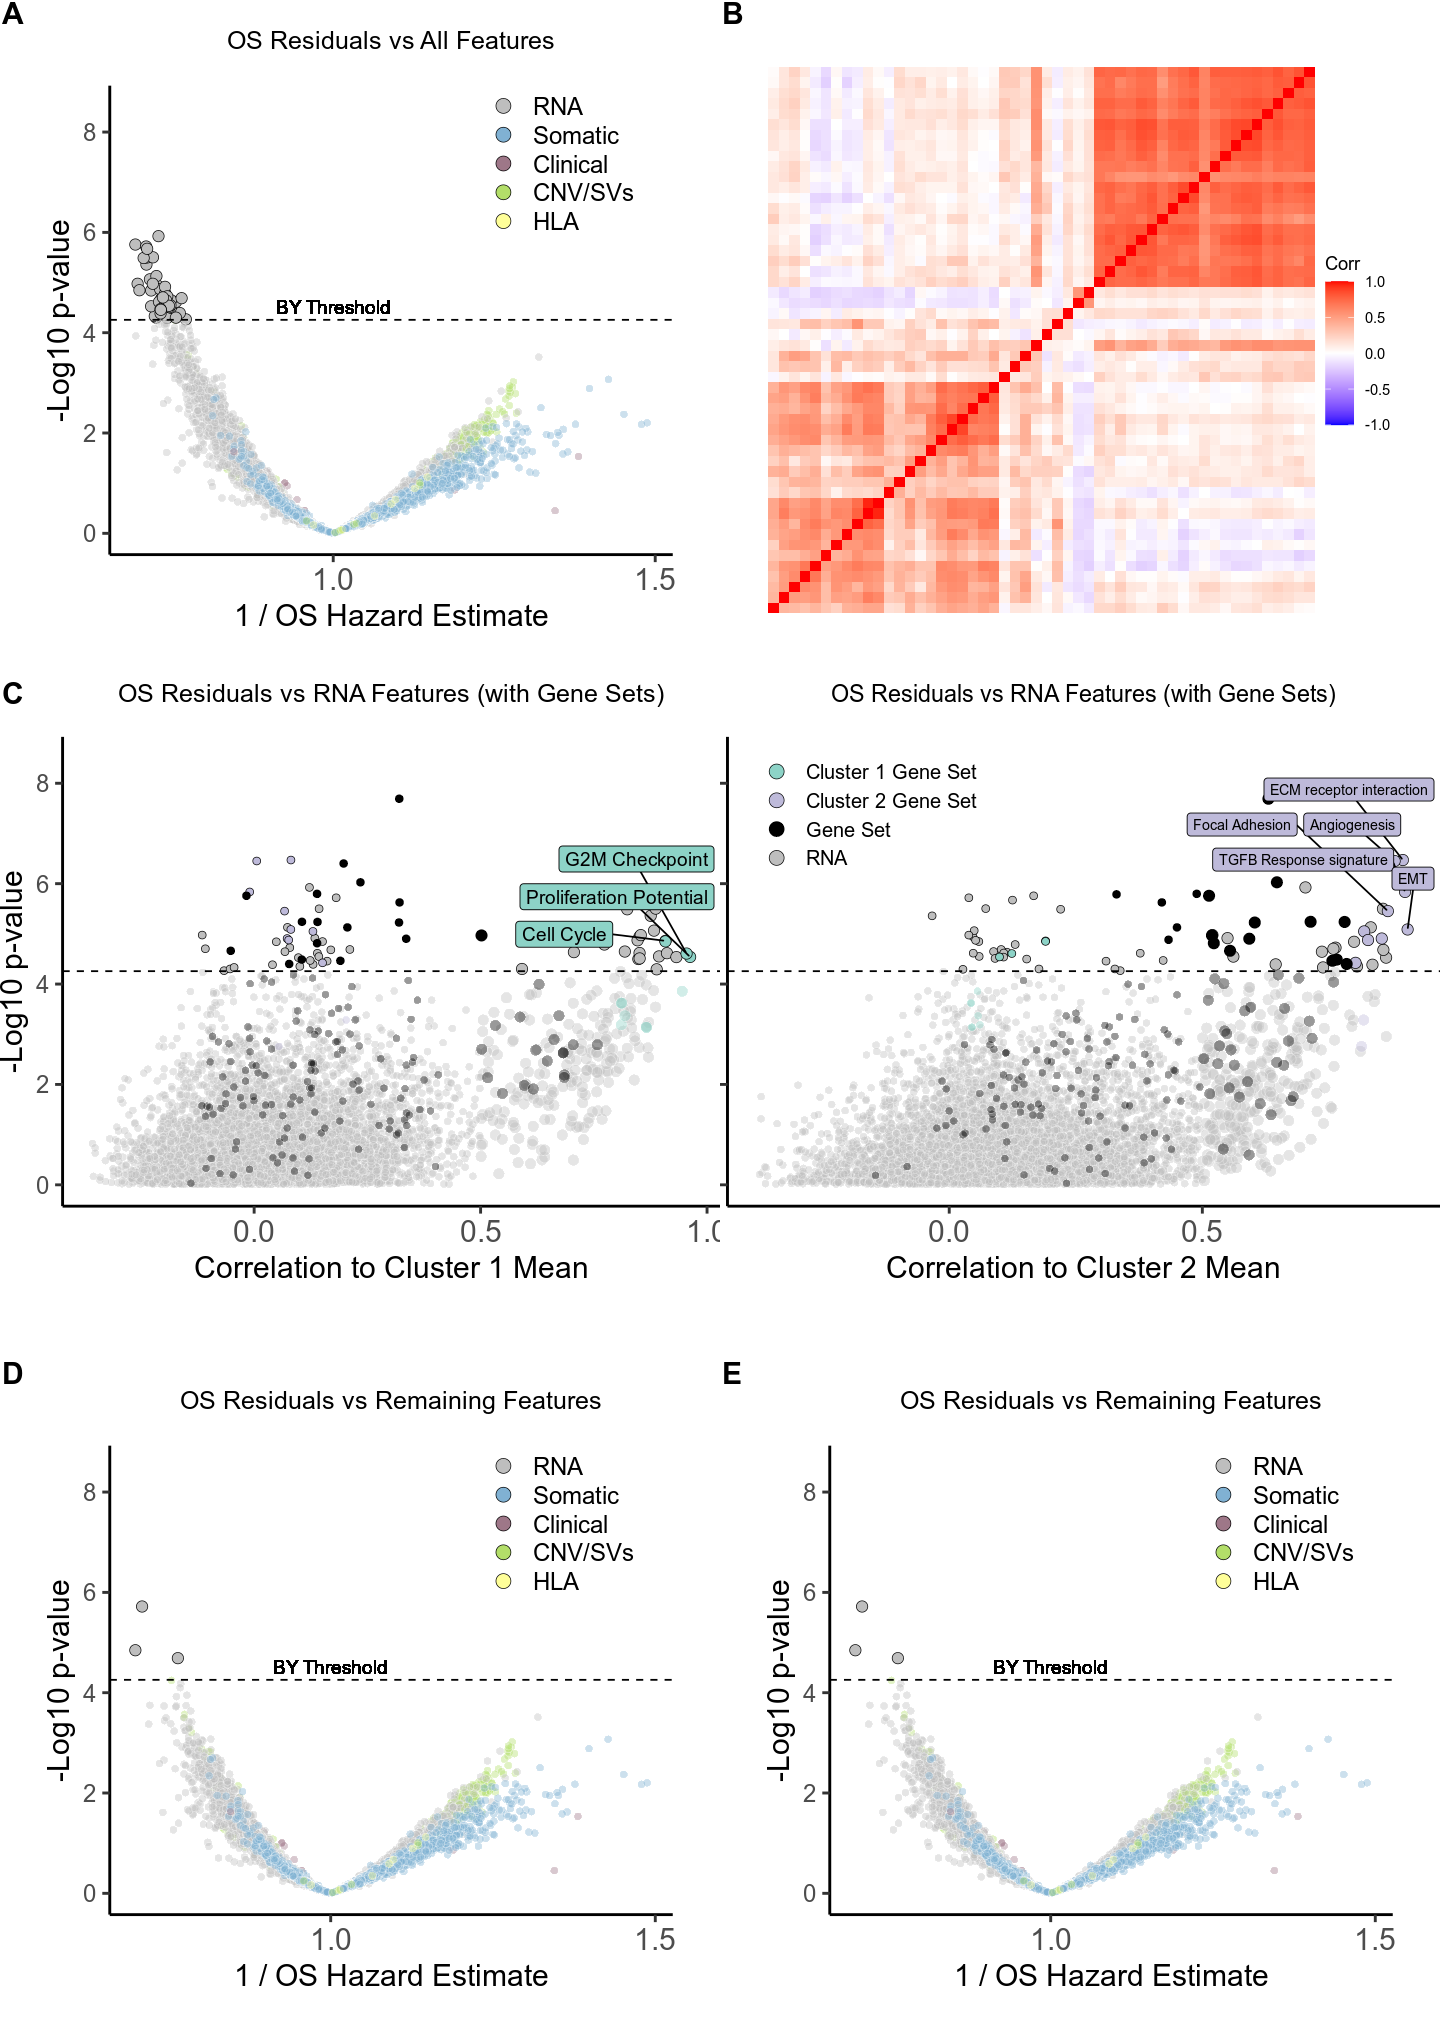

In [28]:
figure3

In [29]:
ggsave( figure3, file = paste0(FIG_FINAL_DIR, "figure3.png"), width = 12, height = 17)